In [1]:
import wandb
import random
import math
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mariemagdalene-spreen (mariemagdalene-spreen-universit-t-osnabr-ck). Use `wandb login --relogin` to force relogin


True

In [2]:
sweep_config = {
    "method": "random"
    }

metric = {
        "name": "val_error",
        "goal": "minimize"
        }

sweep_config["metric"] = metric

parameters_dict = {
        "lr_pi": {
            "min": 0.001,
            "max": 0.01
            },
        "lr_ip": {
            "min": 0.0001,
            "max": 0.001
            },
        "n_samples": {
            "value": 1000
            },
        "noise": {
            "value": 0.3
            },
        "hidden_size": {
            "value": 20
            },
        "batch_size": {
            "values": [1, 10, 100]
            },
        "actfunc": {
            "value": "logexp"
            },
        "tau_weights": {
            "min": 1,
            "max": 30
            }
        }   

sweep_config["parameters"] = parameters_dict

In [3]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'val_error'},
 'parameters': {'actfunc': {'value': 'logexp'},
                'batch_size': {'values': [1, 10, 100]},
                'hidden_size': {'value': 20},
                'lr_ip': {'max': 0.001, 'min': 0.0001},
                'lr_pi': {'max': 0.01, 'min': 0.001},
                'n_samples': {'value': 1000},
                'noise': {'value': 0.3},
                'tau_weights': {'max': 30, 'min': 1}}}


In [4]:
sweep_id = wandb.sweep(sweep_config, project="thesis")

Create sweep with ID: wvqww0m8
Sweep URL: https://wandb.ai/mariemagdalene-spreen-universit-t-osnabr-ck/thesis/sweeps/wvqww0m8


In [7]:
import torch.optim as optim
from training_and_eval import create_dataset, self_pred_training 
from netClasses import *
from tqdm import tqdm
from plotFunctions import *

T = 1000
DT = 0.1
TAU_NEU = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hardsigm(x):
    return x.clamp(min=-1).clamp(max=1)

def tanh(x):
    return torch.tanh(x)

def logexp(x):
    return torch.log(0 + torch.exp(x))

def softrelu(x):
    gamma = 0.1
    beta = 1
    theta = 3
    return gamma * torch.log(1 + torch.exp(beta * (x - theta)))


def activation_function(actfunc):
    if actfunc == "logexp":
        return logexp
    elif actfunc == "hardsigm":
        return hardsigm
    elif actfunc == "tanh":
        return tanh
    elif actfunc == "softrelu":
        return softrelu


def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        rho = activation_function(config.actfunc)
        torch.manual_seed(0)
        net = dendriticNet(
            T,
            DT,
            config.batch_size,
            size_tab=[30, config.hidden_size, 10],
            lr_pf=[0, 0],
            lr_ip=[config.lr_ip],
            lr_pi=[config.lr_pi],
            lr_pb=[0],
            ga=0.8,
            gb=1,
            gd=1,
            glk=0.1,
            gsom=0.8,
            noise=0.3,
            tau_weights=config.tau_weights,
            rho=rho,
            initw=1,
        )
        torch.manual_seed(0)
        data = create_dataset(config.n_samples, config.batch_size, 30, 0, 1, DEVICE)  
        net.to(DEVICE)
        net.train()
        with torch.no_grad():
            data_trace = data[0].clone()
            va_topdown_hist=[]
            va_cancelation_hist=[]
            wpf_hist=[]
            wpb_hist=[]
            wpi_hist=[]
            wip_hist=[]
            for n in tqdm(range(data.shape[0])):
                for k in range(T):
                    # low-pass filter the data
                    data_trace += (DT / TAU_NEU) * (-data_trace + data[n])
                    va = net.stepper(data_trace
                    # Track apical potential, neurons and synapses
                    if k == 0 and n % 20 == 0:
                        va_topdown, va_cancelation = va
                        # Update the tabs with the current values
                        va_topdown_hist = net.updateHist(va_topdown_hist, va_topdown)
                        va_cancelation_hist = net.updateHist(
                            va_cancelation_hist, va_cancelation
                        )
                        wpf_hist = net.updateHist(wpf_hist, net.wpf, param=True)
                        wpb_hist = net.updateHist(wpb_hist, net.wpb, param=True)
                        wpi_hist = net.updateHist(wpi_hist, net.wpi, param=True)
                        wip_hist = net.updateHist(wip_hist, net.wip, param=True)

                    # Update the pyramidal-to-interneuron weights (NOT the pyramidal-to-pyramidal weights !)
                    net.updateWeights(data[n])

                va_topdown, va_cancelation = va
                apical_distance = (
                    ((va_topdown[0] + va_cancelation[0]) ** 2)
                    .cpu()
                    .numpy()
                    .mean(1)
                )
                print(apical_distance)
                sqrd_frob_norm_wpb_wpi = (torch.norm(net.wpb[0].weight.unsqueeze(2) - net.wpi[0].weight.unsqueeze(2), p="fro", dim=(0, 1)) ** 2)
                sqrd_frob_norm_wpf_wip = (torch.norm(net.wpf[1].weight.unsqueeze(2) - net.wip[0].weight.unsqueeze(2), p="fro", dim=(0, 1)) ** 2)
                wandb.log(
                    {
                        "apical_distance": apical_distance,
                        "sqrd_frob_norm_wpb_wpi": sqrd_frob_norm_wpb_wpi,
                        "sqrd_frob_norm_wpf_wip": sqrd_frob_norm_wpf_wip
                    }
                )
        # save the weights in a file named after the wandb run
        net.save_weights(wandb.run.name)

        plot_synapse_distance(
            r"learning_selfpred ({}eps): synapse distance".format(n),
            net.net_depth + 1,
            wpf_hist,
            wpb_hist,
            wpi_hist,
            wip_hist,
        )

        plot_synapse_trace(
            r"learning_selfpred ({}eps): synapse trace".format(n),
            net.net_depth + 1,
            wpf_hist,
            wpb_hist,
            wpi_hist,
            wip_hist,
        )
        plot_apical_distance(
            r"learning_selfpred ({}eps): apical distance".format(n),
            net.net_depth + 1,
            va_topdown_hist,
            va_cancelation_hist,
        )

wandb: Agent Starting Run: l5ip2trn with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 1
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0008278927469509871
wandb: 	lr_pi: 0.0040261158016644035
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 13


100%|██████████| 1000/1000 [09:03<00:00,  1.84it/s]


apical_distance,▃▄█▃▅▃▄▂▅▄▃▂▂▂▃▂▂▂▁▂▂▁▁▁▂▂▁▁▃▁▂▁▁▁▁▂▂▂▁▁
sqrd_frob_norm_wpb_wpi,█▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,██▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
apical_distance,0.01339
sqrd_frob_norm_wpb_wpi,92.22871
sqrd_frob_norm_wpf_wip,127.00405


wandb: Agent Starting Run: zxd1p8e0 with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 1
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0009415794222257648
wandb: 	lr_pi: 0.0051237821665829795
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 14


100%|██████████| 1000/1000 [09:00<00:00,  1.85it/s]


apical_distance,▄▂▂▆▆▃▆▂▆▂█▃▂▂▂▃▁▃▂▂▂▂▂▁▁▃▂▂▁▁▂▁▂▂▂▂▁▂▁▂
sqrd_frob_norm_wpb_wpi,█▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
apical_distance,0.01098
sqrd_frob_norm_wpb_wpi,90.10633
sqrd_frob_norm_wpf_wip,126.44612


wandb: Agent Starting Run: 07e8hbh7 with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 1
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0005918068700083
wandb: 	lr_pi: 0.0011324721083106387
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 16


100%|██████████| 1000/1000 [09:03<00:00,  1.84it/s]


apical_distance,▃█▂▃▂▁▃▂▂▂▄▃▄▁▂▁▅▂▃▁▁▂▂▁▂▂▁▂▃▂▂▁▁▁▁▁▁▁▂▁
sqrd_frob_norm_wpb_wpi,████▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
apical_distance,0.03908
sqrd_frob_norm_wpb_wpi,112.44205
sqrd_frob_norm_wpf_wip,130.69897


wandb: Agent Starting Run: cj68ujkc with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 100
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.00014319712391009862
wandb: 	lr_pi: 0.003661148844604028
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 10


100%|██████████| 1000/1000 [11:22<00:00,  1.47it/s]


apical_distance,█▂▂▁▂▂▂▁▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpb_wpi,██▇▇▇▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
apical_distance,0.00705
sqrd_frob_norm_wpb_wpi,88.03497
sqrd_frob_norm_wpf_wip,137.59373


wandb: Agent Starting Run: r4eozucc with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 1
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.00030523695409237554
wandb: 	lr_pi: 0.0033632146723725303
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 21


100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s]


apical_distance,█▃▃▃▇▆▃▃▂▂▃▂▂▁▁▂▂▂▂▃▂▃▁▁▁▂▁▂▁▁▁▁▁▃▁▁▂▁▁▁
sqrd_frob_norm_wpb_wpi,█▇▇▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
sqrd_frob_norm_wpf_wip,███▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
apical_distance,0.02577
sqrd_frob_norm_wpb_wpi,100.77835
sqrd_frob_norm_wpf_wip,135.86028


wandb: Agent Starting Run: 8ugpr24q with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 100
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0003744553024109748
wandb: 	lr_pi: 0.0029893516735213
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 4


100%|██████████| 1000/1000 [10:00<00:00,  1.66it/s]


apical_distance,█▂▁▃▂▄▂▂▂▂▁▂▁▂▂▁▁▂▂▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▂
sqrd_frob_norm_wpb_wpi,█▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,█████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
apical_distance,0.00695
sqrd_frob_norm_wpb_wpi,81.25811
sqrd_frob_norm_wpf_wip,123.9279


wandb: Agent Starting Run: llk1lugi with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 100
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0007375409830322191
wandb: 	lr_pi: 0.006017061724385088
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 17


100%|██████████| 1000/1000 [10:04<00:00,  1.65it/s]
/home/marie/Documents/UniOsna/bachelorarbeit/DendriticCorticalMicrocircuitThesis/plotFunctions.py:330: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 2 * (net_depth - 1)))


apical_distance,▅▇█▄▂▃▂▃▂▂▂▂▂▁▁▂▂▂▁▂▂▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpb_wpi,██▇▇▇▆▆▆▆▆▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,█▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
apical_distance,0.00683
sqrd_frob_norm_wpb_wpi,88.88976
sqrd_frob_norm_wpf_wip,131.41544


wandb: Agent Starting Run: 415dc5pl with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 100
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0008561567199328919
wandb: 	lr_pi: 0.008175294694881614
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 22


100%|██████████| 1000/1000 [10:02<00:00,  1.66it/s]


apical_distance,█▃▄▄▂▃▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpb_wpi,██▇▇▇▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁
apical_distance,0.0069
sqrd_frob_norm_wpb_wpi,88.20367
sqrd_frob_norm_wpf_wip,132.17935


wandb: Agent Starting Run: kwswdc3h with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 10
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.0006642076911819123
wandb: 	lr_pi: 0.0052752490204638755
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 9


100%|██████████| 1000/1000 [08:28<00:00,  1.96it/s]


apical_distance,█▆▃▃▅▃▂▃▂▃▂▆▃▂▂▃▂▁▂▃▂▂▁▁▃▂▁▁▁▂▂▂▂▃▁▁▂▂▁▁
sqrd_frob_norm_wpb_wpi,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,████▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
apical_distance,0.004
sqrd_frob_norm_wpb_wpi,83.35631
sqrd_frob_norm_wpf_wip,126.60623


wandb: Agent Starting Run: w8jpaiec with config:
wandb: 	actfunc: logexp
wandb: 	batch_size: 10
wandb: 	hidden_size: 20
wandb: 	lr_ip: 0.00047108642905871625
wandb: 	lr_pi: 0.008856537785108802
wandb: 	n_samples: 1000
wandb: 	noise: 0.3
wandb: 	tau_weights: 10


100%|██████████| 1000/1000 [08:29<00:00,  1.96it/s]


apical_distance,▄█▅▆█▄▃▁▂▁▂▂▂▂▃▂▂▂▁▂▃▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁
sqrd_frob_norm_wpb_wpi,███▇▆▆▅▅▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
sqrd_frob_norm_wpf_wip,█▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
apical_distance,0.00322
sqrd_frob_norm_wpb_wpi,79.72658
sqrd_frob_norm_wpf_wip,130.62793


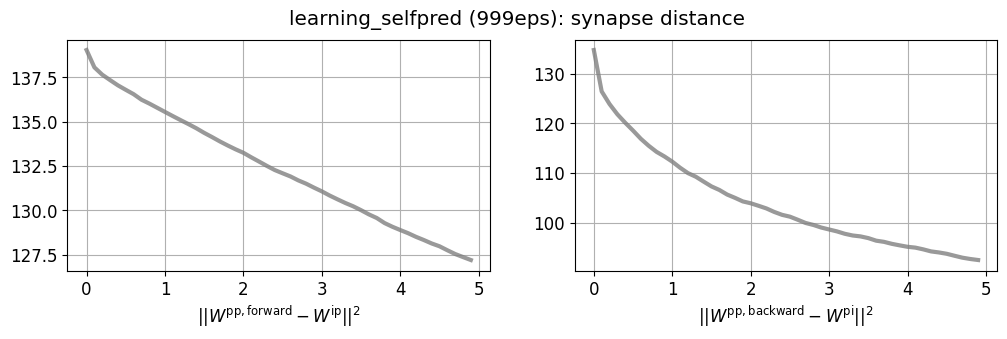

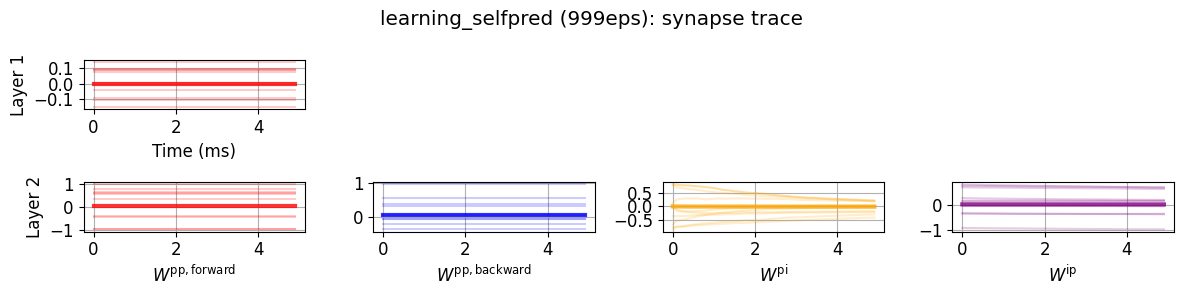

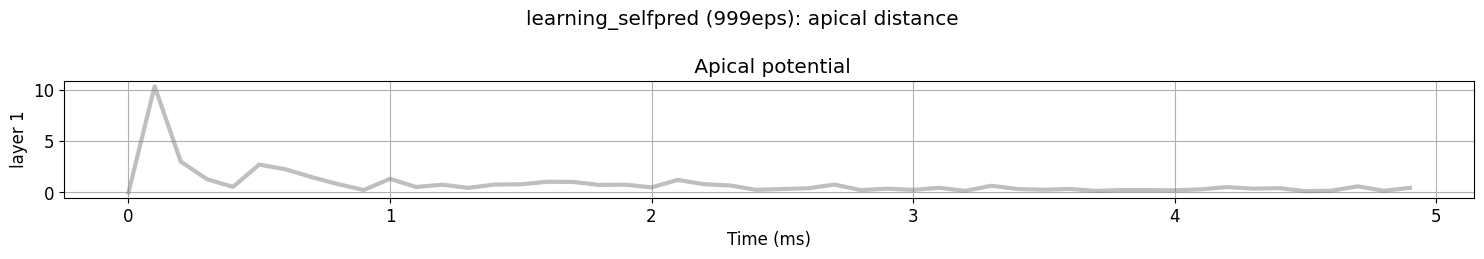

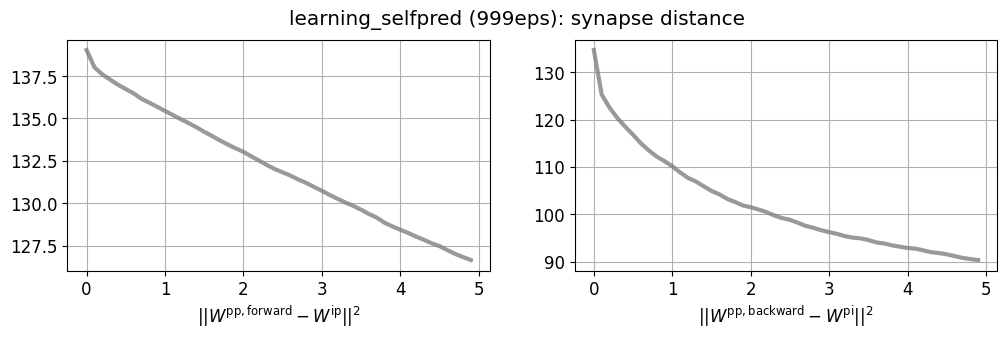

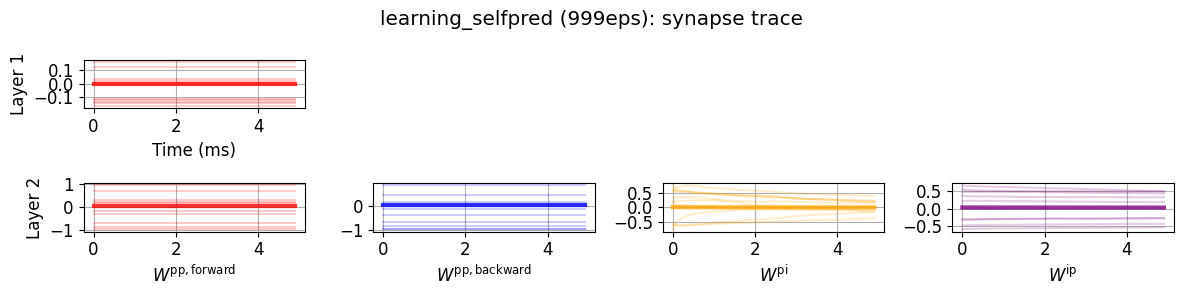

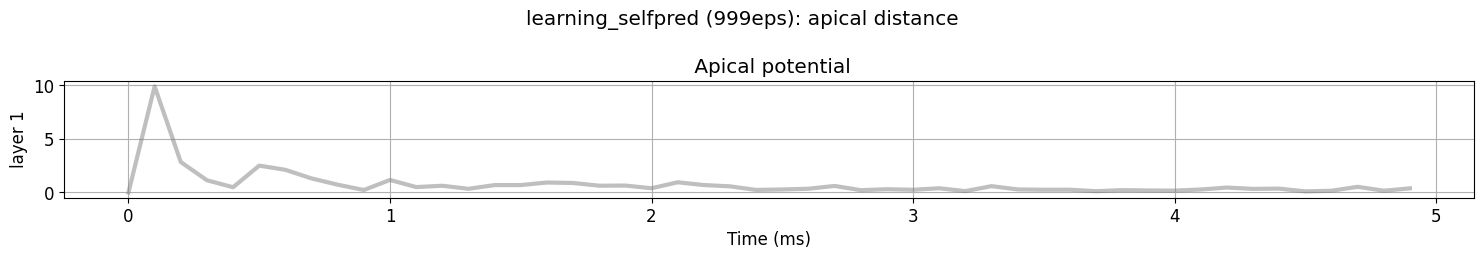

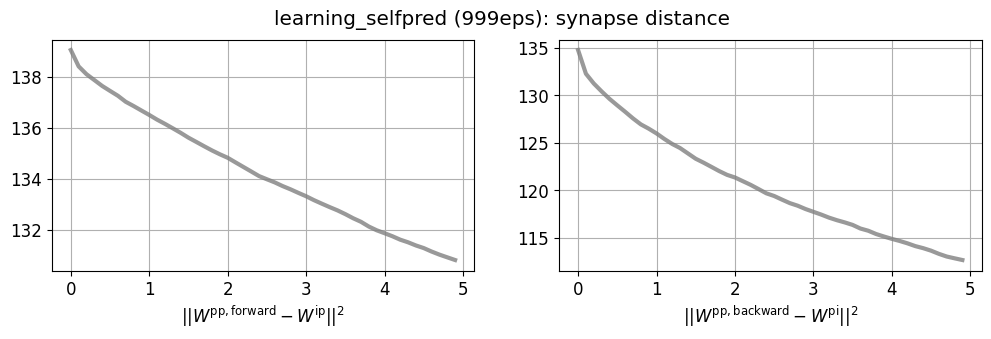

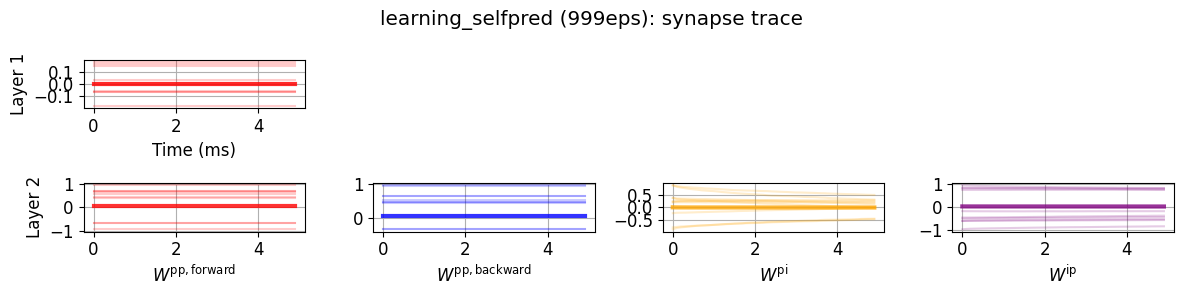

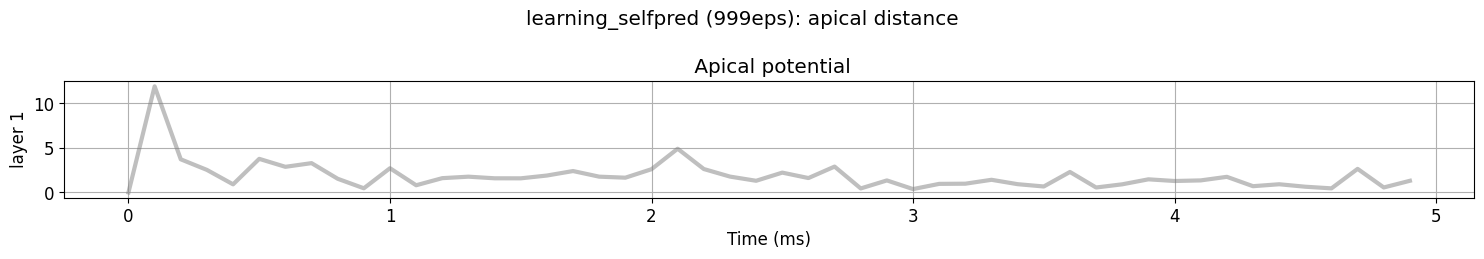

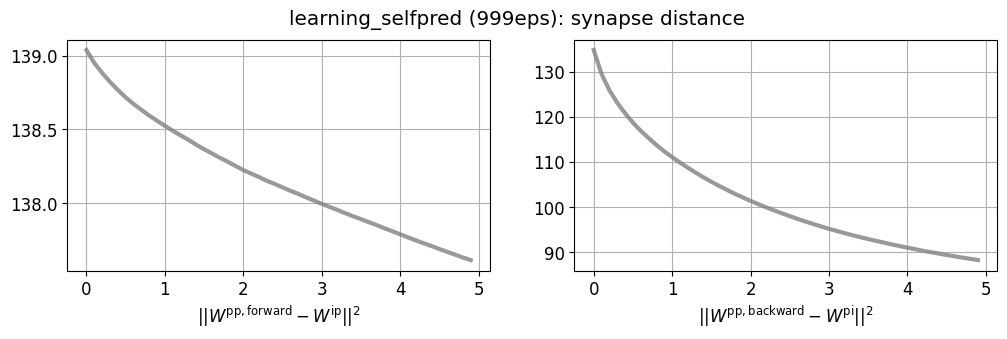

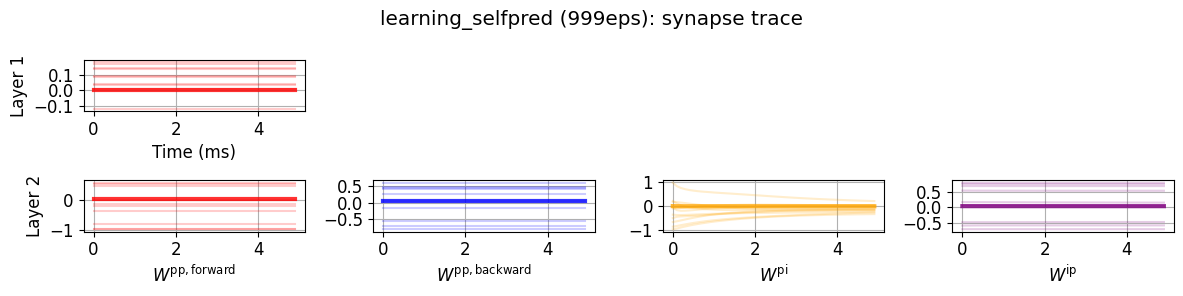

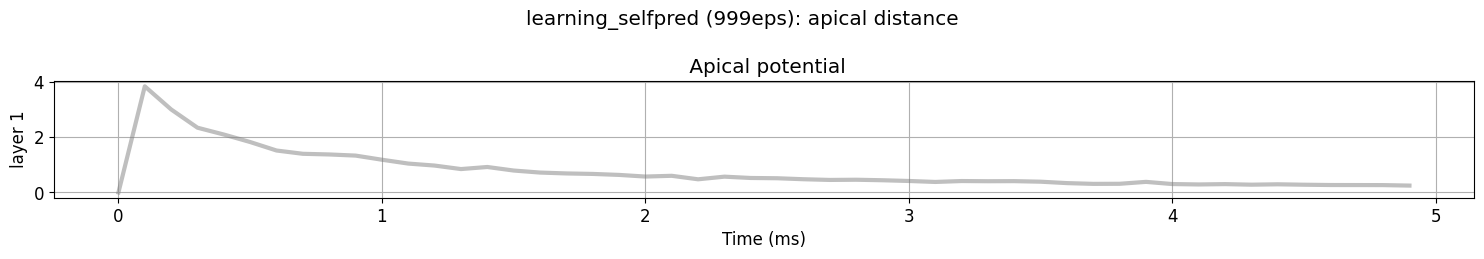

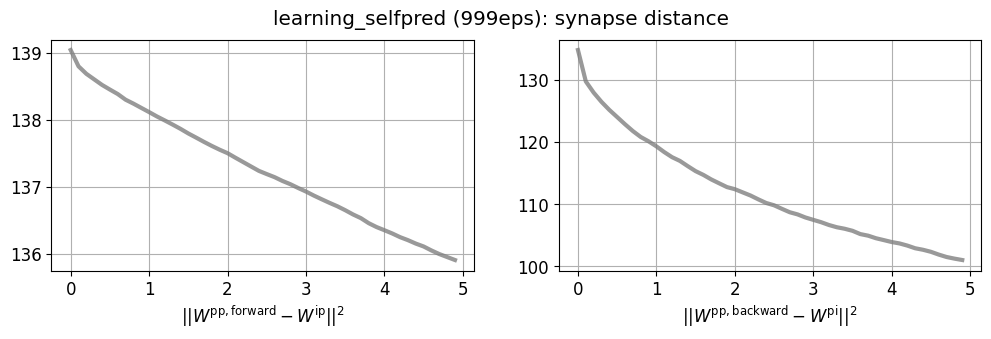

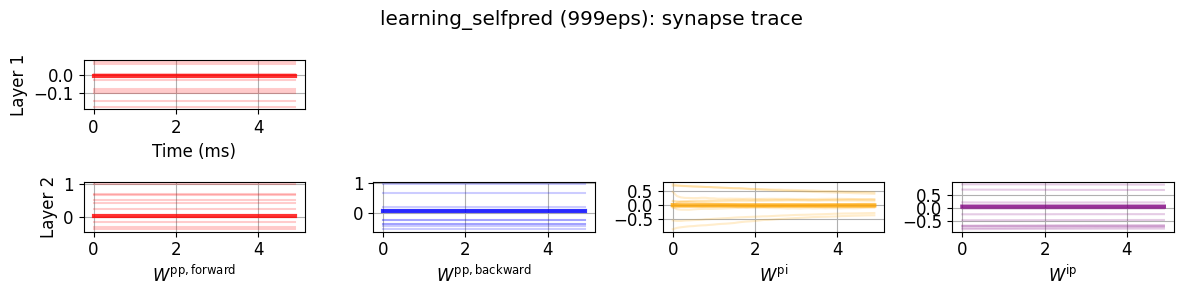

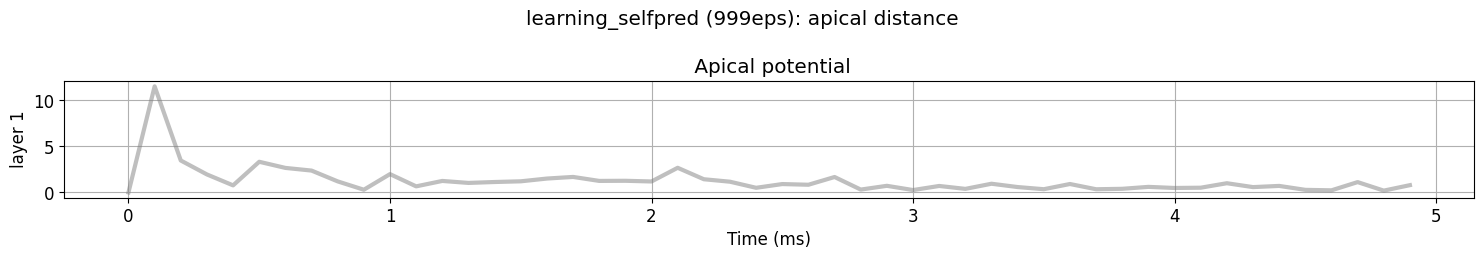

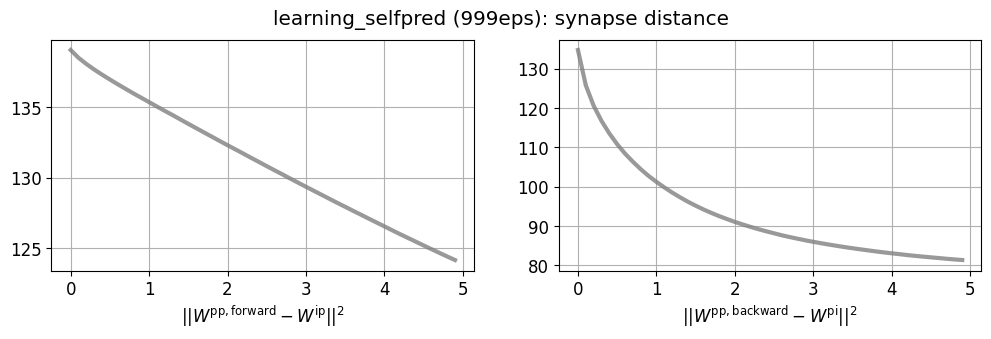

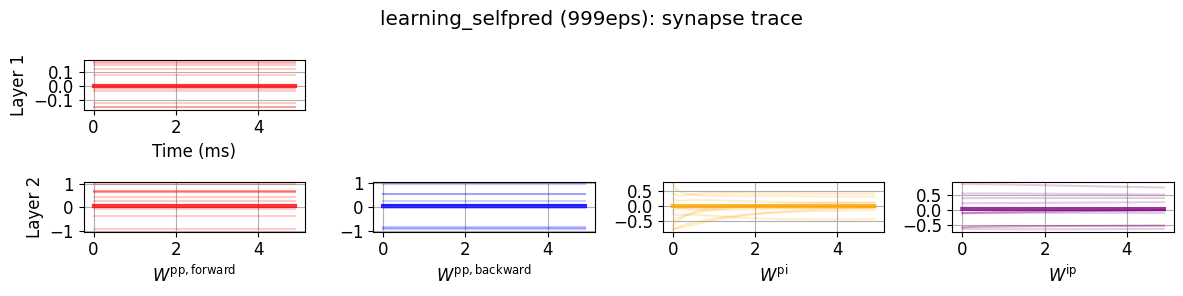

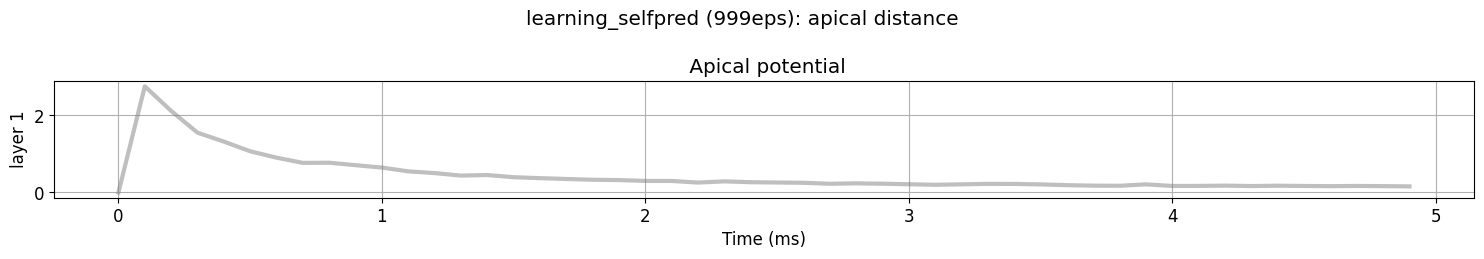

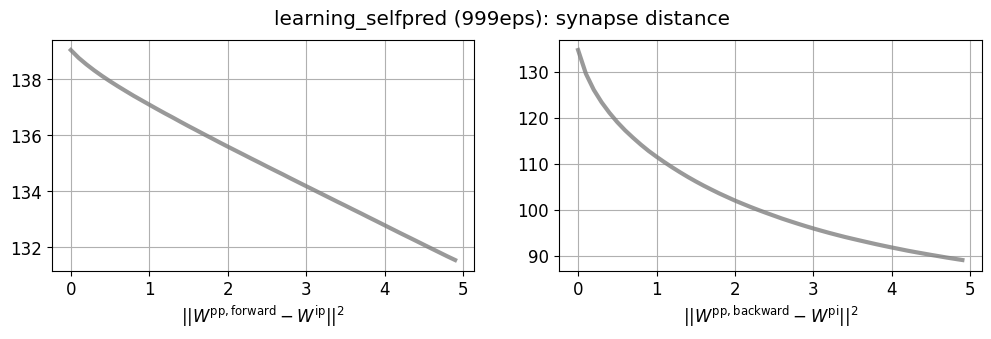

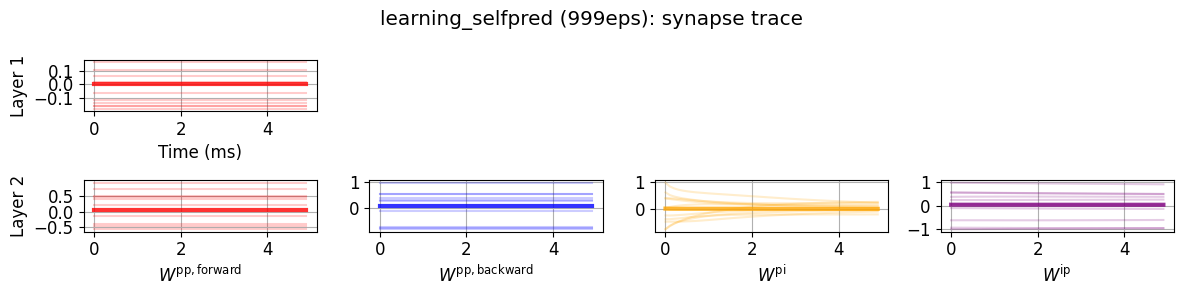

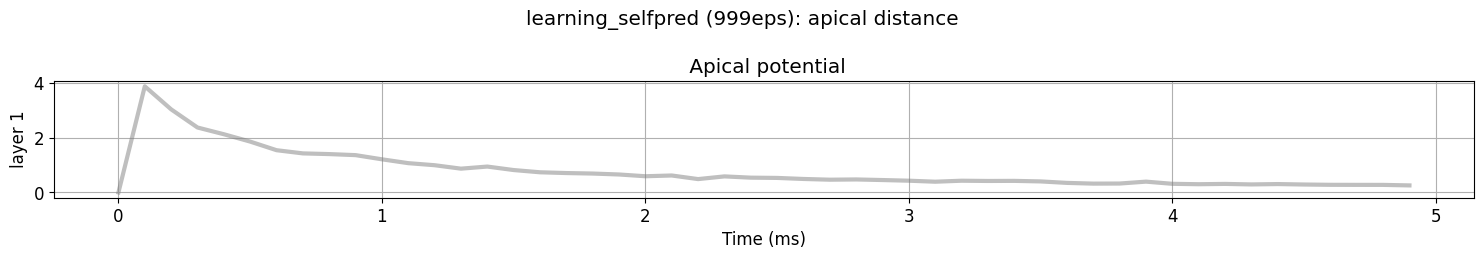

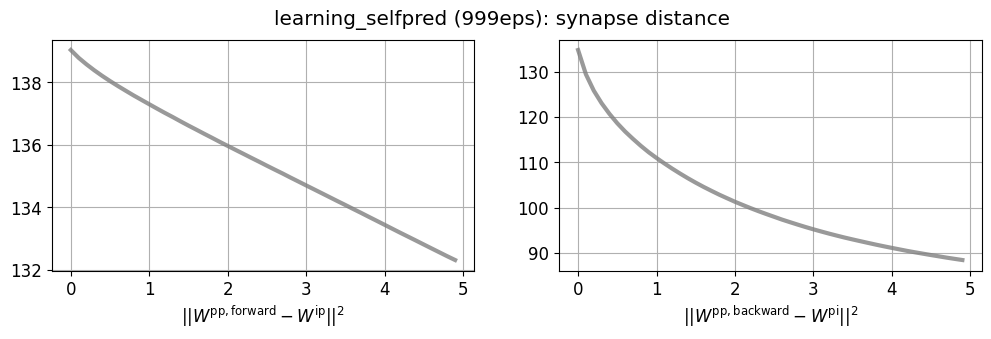

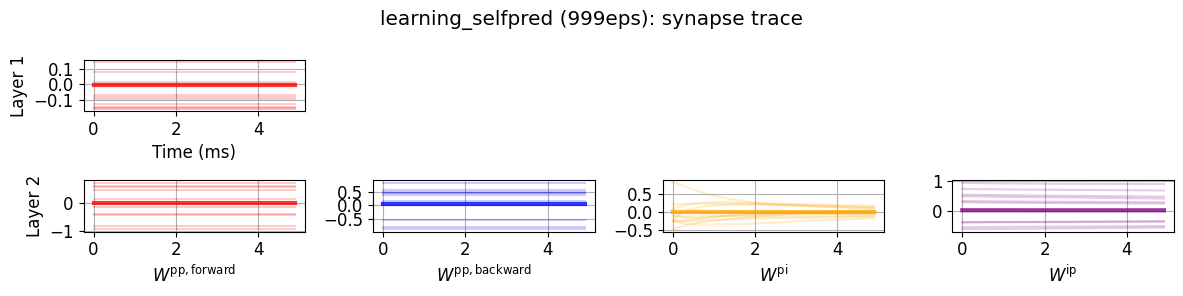

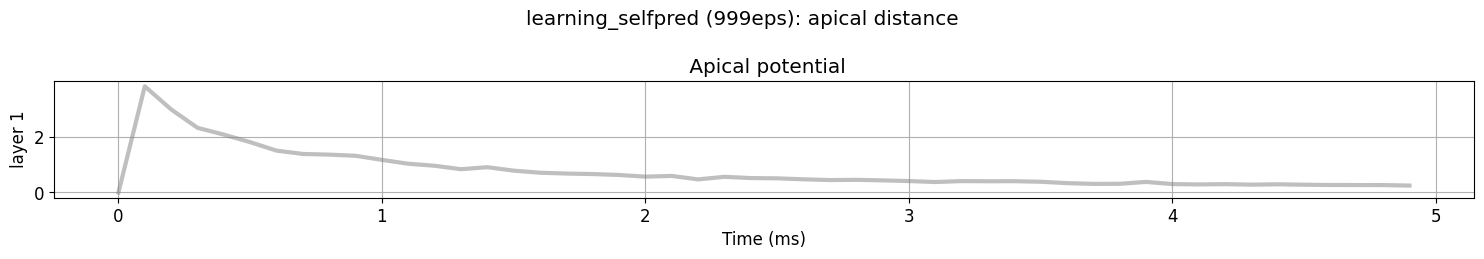

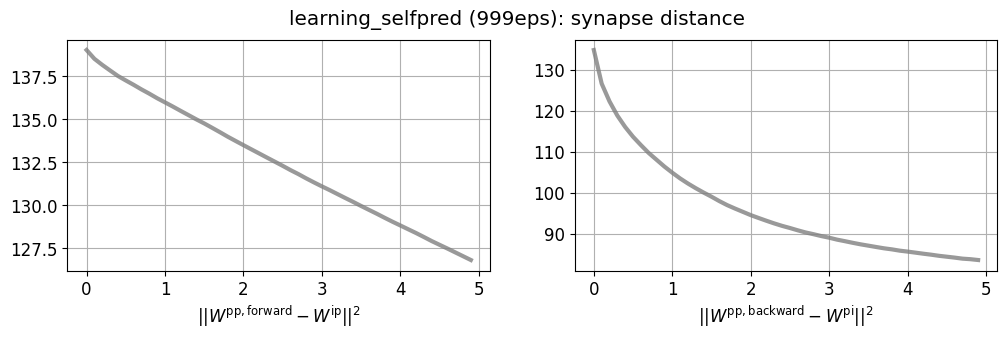

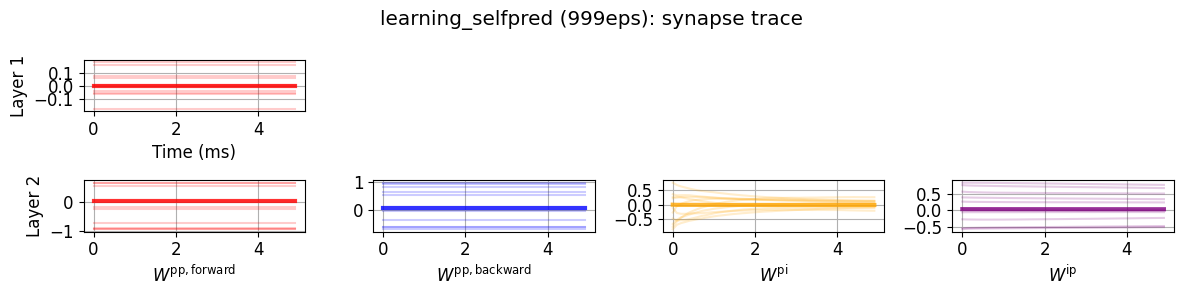

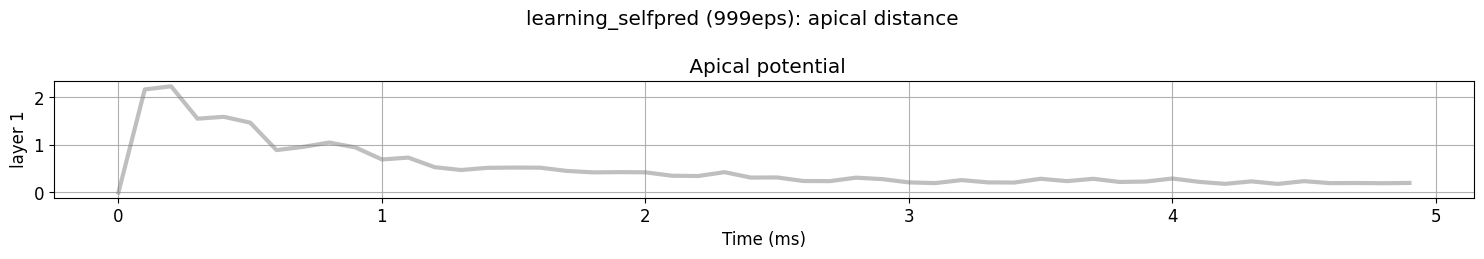

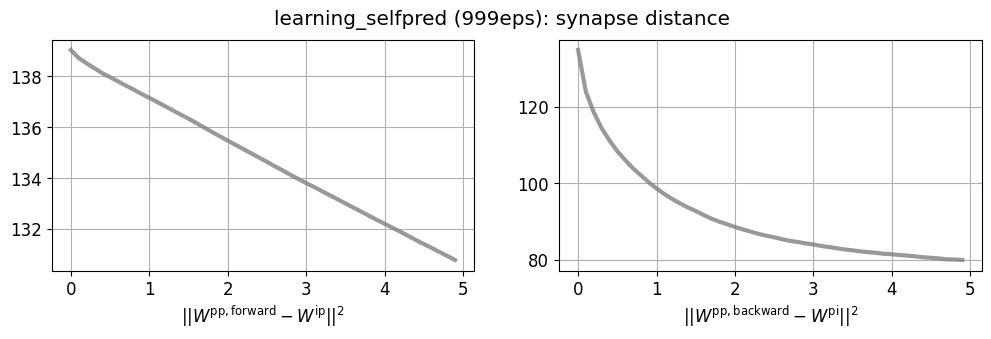

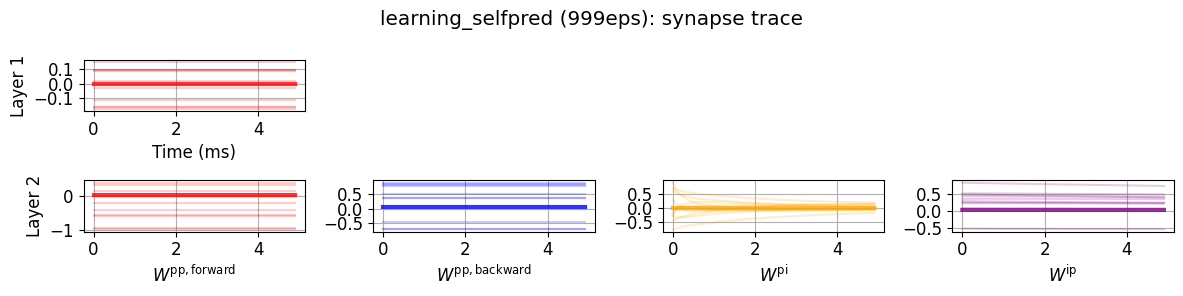

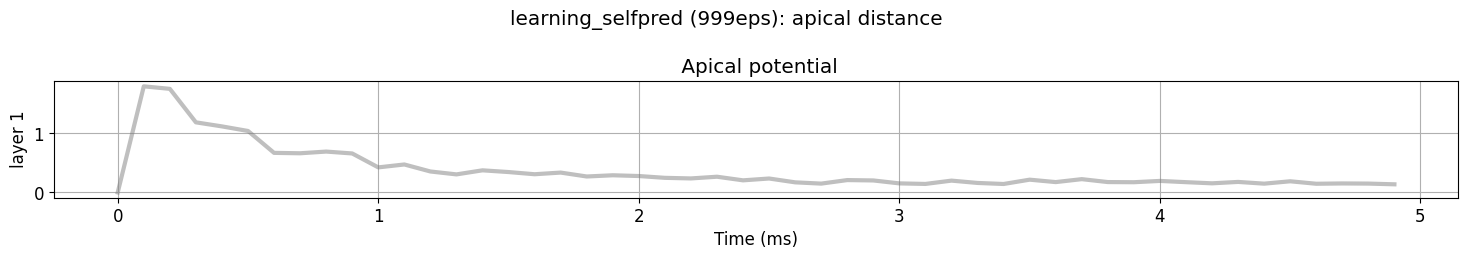

In [9]:
wandb.agent(sweep_id, train, count=10)